In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Unpack wordnet.zip
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Data Loading

In [3]:
# Load Data
video_df = pd.read_csv("kaggle/input/youtube-statistics/videos-stats.csv")
comm_df = pd.read_csv("kaggle/input/youtube-statistics/comments.csv")

# Drop Unnamed: 0 column
video_df = video_df.drop(columns=["Unnamed: 0"])
comm_df = comm_df.drop(columns=["Unnamed: 0"])

# Drop nan values
video_df = video_df.dropna()
comm_df = comm_df.dropna()

# Drop duplicates
video_df.drop_duplicates(keep='first', inplace=True)
comm_df.drop_duplicates(keep='first', inplace=True)

# Cast columns to int
video_df["Likes"] = video_df["Likes"].astype(int)
video_df["Comments"] = video_df["Comments"].astype(int)
video_df["Views"] = video_df["Views"].astype(int)
comm_df["Likes"] = comm_df["Likes"].astype(int)
comm_df["Sentiment"] = comm_df["Sentiment"].astype(int)

# One hot encoding 'Sentiment' column
comm_df = pd.get_dummies(comm_df, columns=['Sentiment'])

# Preprocessing

In [4]:
import emoji
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def clean_text(text):
       
    # Remove \r and \n
    text = text.replace('\r', '').replace('\n', ' ')

    # Remove emojis
    text = emoji.demojize(text)

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Convert to lowercase and remove non-alphabetic tokens
    tokens = [t.lower() for t in tokens if t.isalpha()]
    
    # Remove stop words and punctuation, and lemmatize
    stop_words = stopwords.words('english')
    punctuation = list(string.punctuation)
    tokens_to_remove = stop_words + punctuation
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(t) for t in tokens if t not in tokens_to_remove]

    return ' '.join(tokens)

def preprocess_df(df):
    # Clean the comments
    df['Comment_cleaned'] = df['Comment'].apply(clean_text)

    # Add comment lengths
    df['Comment Length'] = df['Comment_cleaned'].apply(lambda x: len(str(x).split()))

    # Removing empty comments
    new_df = df[df['Comment Length'] > 0]

    # Remove outliers
    new_df = new_df[new_df['Comment Length'] <= 50]
    
    return new_df

c:\Users\husey\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
new_comm_df = preprocess_df(comm_df)
max_seq_len = 50

# Define features and target columns
X = new_comm_df['Comment_cleaned']
y = np.array(new_comm_df[['Sentiment_0', 'Sentiment_1', 'Sentiment_2']])

In [6]:
new_comm_df

,Video ID,Comment,Likes,Sentiment_0,Sentiment_1,Sentiment_2,Comment_cleaned,Comment Length
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,False,True,False,let forget apple pay required brand new iphone...,32
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,True,False,False,nz retailer even contactless credit card machi...,15
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,False,False,True,forever acknowledge channel help lesson idea e...,14
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,True,False,False,whenever go place take apple pay happen often ...,42
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,False,False,True,apple pay convenient secure easy use used kore...,14
...,...,...,...,...,...,...,...,...
18404,cyLWtMSry58,I really like the point about engineering tool...,0,False,False,True,really like point engineering toolbox think lo...,30
18405,cyLWtMSry58,I’ve just started exploring this field. And th...,20,False,False,True,started exploring field really good reminder g...,11
18406,cyLWtMSry58,Excelente video con una pregunta filosófica pr...,1,False,True,False,excelente video con una pregunta filosófica pr...,39
18407,cyLWtMSry58,"Hey Daniel, just discovered your channel a cou...",35,False,False,True,hey daniel discovered channel couple day ago l...,10


In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Functions to plot confusion matrices and calculate accuracies

def plot_conf_matrix(y_test, y_pred):
    y_pred_arg = np.argmax(y_pred, axis=1)
    y_test_arg = np.argmax(y_test, axis=1)
    
    cm = confusion_matrix(y_test_arg, y_pred_arg)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
    
    cmdisp.plot()
    plt.show()
    
def calculate_acc(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred.round())
    print('Accuracy:', accuracy)

# Train-Test Splitting

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=24)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=24)

# Sentiment Analysis Model_1 (glove-wiki-gigaword-50)

## Applying Pre-trained glove-wiki-gigaword-50 Word2Vec Model

In [9]:
from gensim.models import Word2Vec
import gensim.downloader as api

gigaword_50_wv = api.load("glove-wiki-gigaword-50")

In [10]:
vocabulary_size = api.info()['models']['glove-wiki-gigaword-50']['num_records']
embedding_dim = gigaword_50_wv.vector_size

In [125]:
def comment_embedding(comments, word2vec_model):
    tokens = [comment.split() for comment in comments.tolist()]
    embeddings = [word2vec_model.get_mean_vector(token, ignore_missing=True) for token in tokens]
    return embeddings

In [126]:
X_train_emb = np.array(comment_embedding(X_train, gigaword_50_wv))
X_test_emb = np.array(comment_embedding(X_test, gigaword_50_wv))
X_val_emb = np.array(comment_embedding(X_val, gigaword_50_wv))

## Model Development

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Create model
model = Sequential([InputLayer(shape=(embedding_dim,)),
                    Dense(256, activation="relu"),
                    Dropout(0.1),
                    Dense(512, activation="relu"),
                    Dropout(0.1),
                    Dense(512, activation="relu"),
                    Dropout(0.1),
                    Dense(256, activation="relu"),
                    Dropout(0.1),
                    Dense(3, activation="softmax")], name="model_1")

optimizer = Adam(learning_rate=1e-3)

# Compile model
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

model.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_115 (Dense)               │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,395 (2.06 MB)

 Trainable params: 539,395 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Train the model
history = model.fit(X_train_emb, y_train, epochs=30, batch_size=32, validation_data=(X_val_emb, y_val), callbacks=[early_stopping])

Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6862 - loss: 0.7371 - val_accuracy: 0.7125 - val_loss: 0.6676
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7406 - loss: 0.6276 - val_accuracy: 0.7234 - val_loss: 0.6483
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7469 - loss: 0.6044 - val_accuracy: 0.7119 - val_loss: 0.6631
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7502 - loss: 0.5919 - val_accuracy: 0.7166 - val_loss: 0.6576
Epoch 5/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7527 - loss: 0.5811 - val_accuracy: 0.7084 - val_loss: 0.6669
Epoch 6/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7609 - loss: 0.5751 - val_accuracy: 0.7289 - val_loss: 0.6618
Epoch 7/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7684 - loss: 0.5504 - val_accuracy: 0.7228 - val_loss: 0.6629
Epoch 8/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7710 - loss: 0.5390 - val_accuracy: 0.

## Evaluation on Test Set

In [66]:
y_pred = model.predict(X_test_emb)
calculate_acc(y_test, y_pred)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7180378524526845


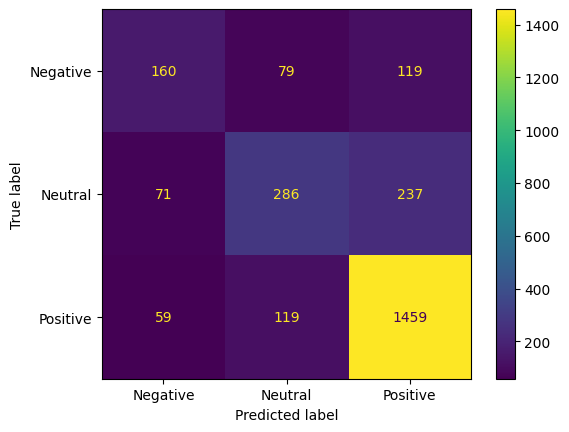

In [67]:
plot_conf_matrix(y_test, y_pred)

# Sentiment Analysis Model_2 (word2vec-google-news-300)

## Applying Pre-trained word2vec-google-news-300 Model

In [113]:
from gensim.models import Word2Vec
import gensim.downloader as api

google_news_300_wv = api.load("word2vec-google-news-300")

In [114]:
vocabulary_size = api.info()['models']['word2vec-google-news-300']['num_records']
embedding_dim = google_news_300_wv.vector_size

In [127]:
X_train_emb = np.array(comment_embedding(X_train, google_news_300_wv))
X_test_emb = np.array(comment_embedding(X_test, google_news_300_wv))
X_val_emb = np.array(comment_embedding(X_val, google_news_300_wv))

## Model Development

In [144]:
# Create model
model_2 = Sequential([InputLayer((embedding_dim,)),
                    Dense(256, activation="relu"),
                    Dropout(0.1),
                    Dense(512, activation="relu"),
                    Dropout(0.1),
                    Dense(512, activation="relu"),
                    Dropout(0.1),
                    Dense(256, activation="relu"),
                    Dropout(0.1),
                    Dense(3, activation="softmax")], name="model_2")

optimizer = Adam(learning_rate=1e-3)

# Compile model
model_2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model_2.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_170 (Dense)               │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,395 (2.30 MB)

 Trainable params: 603,395 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
# Train the model
history_2 = model_2.fit(X_train_emb, y_train, epochs=30, batch_size=32, validation_data=(X_val_emb, y_val), callbacks=[early_stopping])

Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6981 - loss: 0.7028 - val_accuracy: 0.7609 - val_loss: 0.6078
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7745 - loss: 0.5329 - val_accuracy: 0.7698 - val_loss: 0.5529
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7940 - loss: 0.4888 - val_accuracy: 0.7766 - val_loss: 0.5492
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8004 - loss: 0.4779 - val_accuracy: 0.7698 - val_loss: 0.5676
Epoch 5/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8213 - loss: 0.4372 - val_accuracy: 0.7534 - val_loss: 0.6043
Epoch 6/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8336 - loss: 0.4093 - val_accuracy: 0.7677 - val_loss: 0.5809
Epoch 7/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8459 - loss: 0.3721 - val_accuracy: 0.7745 - val_loss: 0.6031
Epoch 8/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8587 - loss: 0.3427 - val_accuracy: 0.

## Evaluation on Test Set

In [146]:
y_pred = model_2.predict(X_test_emb)
calculate_acc(y_test, y_pred)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7524140594824257


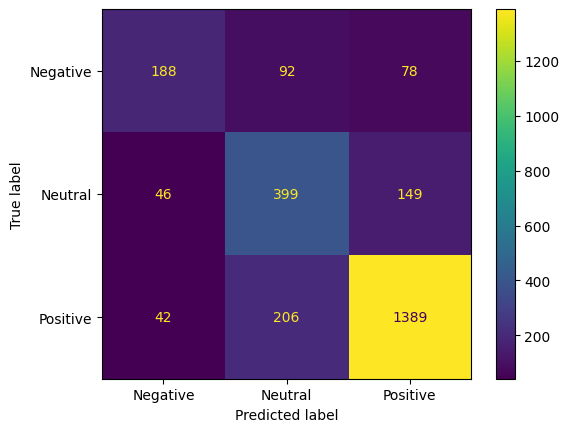

In [147]:
plot_conf_matrix(y_test, y_pred)

# Sentiment Analysis Model_3 (Custom Embedding Layer)

In [76]:
def get_vocab_size(comments):
    vocab = {token for comment in comments for token in comment.split()}
    return len(vocab)

In [77]:
vocabulary_size = get_vocab_size(X)
vocabulary_size

24719

In [80]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X)

# Convert tokens to sequences
sequences = tokenizer.texts_to_sequences(X)

# Padding sequences
X_vectorized = pad_sequences(sequences, maxlen=max_seq_len)

## Train-Test Splitting

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.15, random_state=24)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=24)

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dropout
from keras.regularizers import L1, L2

# Define the model
model_3 = Sequential([Embedding(vocabulary_size, output_dim=200),
                    LSTM(64, return_sequences=True),
                    Dropout(0.1),
                    LSTM(64),
                    Dense(32, activation='relu', 
                          kernel_regularizer=L2(0.01), 
                          activity_regularizer=L1(0.01)),
                    Dense(3, activation='softmax')], name="model_3")

optimizer = Adam(learning_rate=0.01)

# Compile the model
model_3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

model_3.summary()

Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [104]:
print(model_3.layers[0].input_dim)

24719


In [105]:
# Train the model
history_3 = model_3.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.6216 - loss: 1.1026 - val_accuracy: 0.6199 - val_loss: 0.9109
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.6375 - loss: 0.8884 - val_accuracy: 0.6199 - val_loss: 0.9103
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.6376 - loss: 0.8876 - val_accuracy: 0.6199 - val_loss: 0.9098
Epoch 4/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.6416 - loss: 0.8821 - val_accuracy: 0.6199 - val_loss: 0.9099
Epoch 5/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.6377 - loss: 0.8858 - val_accuracy: 0.6199 - val_loss: 0.9098
Epoch 6/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.6361 - loss: 0.8899 - val_accuracy: 0.6199 - val_loss: 0.9106


## Evaluation on Test Set

In [106]:
y_pred = model_3.predict(X_test)
calculate_acc(y_test, y_pred)

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy: 0.6322904596369254


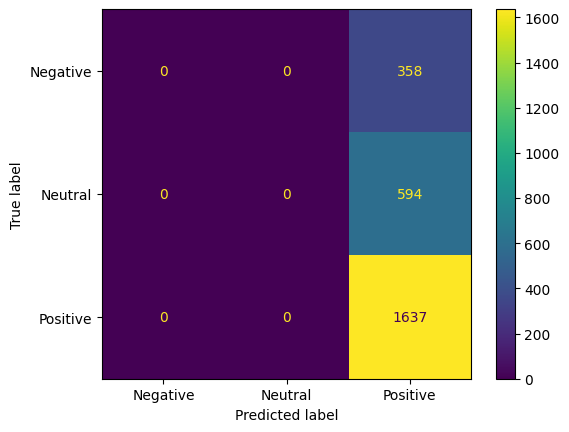

In [107]:
plot_conf_matrix(y_test, y_pred)

# Sentiment Analysis Model_4 (gigaword with lstm model)

In [108]:
vocabulary_size = api.info()['models']['glove-wiki-gigaword-50']['num_records']
embedding_dim = gigaword_50_wv.vector_size

In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dropout
from keras.regularizers import L1, L2

# Define the model
model = Sequential()
model.add(InputLayer((embedding_dim,1)))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=16))
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 50, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,539 (29.45 KB)

 Trainable params: 7,539 (29.45 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# Train the model
history = model.fit(X_train_emb, y_train, epochs=30, batch_size=32, validation_data=(X_val_emb, y_val), callbacks=[early_stopping])

Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6311 - loss: 0.9221 - val_accuracy: 0.6199 - val_loss: 0.9115
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6433 - loss: 0.8740 - val_accuracy: 0.6233 - val_loss: 0.8705
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6540 - loss: 0.8386 - val_accuracy: 0.6601 - val_loss: 0.8382
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6709 - loss: 0.8186 - val_accuracy: 0.6676 - val_loss: 0.8366
Epoch 5/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6660 - loss: 0.8235 - val_accuracy: 0.6662 - val_loss: 0.8317
Epoch 6/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6777 - loss: 0.8022 - val_accuracy: 0.6649 - val_loss: 0.8246
Epoch 7/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6718 - loss: 0.7987 - val_accuracy: 0.6621 - val_loss: 0.8069
Epoch 8/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6761 - loss: 0.7828 - val_accu

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.6353804557744303


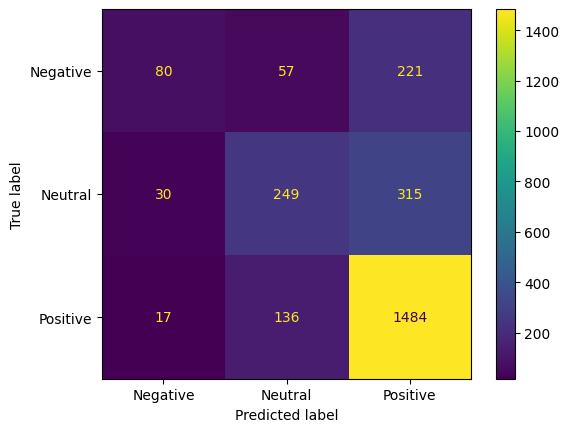

In [111]:
y_pred = model.predict(X_test_emb)
calculate_acc(y_test, y_pred)
plot_conf_matrix(y_test, y_pred)

### Results

***Model 1*** - *(glove-wiki-gigaword-50 Word2Vec)*:    **71.80%**

***Model 2*** - *(word2vec-google-news-300)*:           **75.24%**

***Model 3*** - *(Custom Embedding with LSTM)*:         **63.22%**

***Model 4*** - *(glove-wiki-gigaword-50 with LSTM)*:   **63.53%**


### Key Observations

**Word Embeddings Matter:** The fact that ***Model 2*** *(word2vec-google-news-300)* outperformed ***Model 1*** *(glove-wiki-gigaword-50)* suggests that the quality and source of your word embeddings have a significant impact on sentiment analysis. The word2vec embeddings trained on Google News data likely capture more nuances of language used in online comments.

**Simple vs. Complex:** Interestingly, the simpler models *(1 and 2)* that use pre-trained word embeddings without complex neural network architectures like LSTM perform better. This is a common finding in text classification tasks, where simpler models can sometimes generalize better to new data.

**Custom Embedding Challenges:**  ***Model 3***, with our custom embedding, underperforms. This is not uncommon, as creating effective custom embeddings requires a lot of carefully labeled data. It's possible and we had that our custom embeddings didn't capture enough semantic information or were overfitted to our training data.

**LSTM Might Not Be Ideal:** The models using ***LSTM*** *(3 and 4)* don't seem to be adding much value. This could be because LSTM models are better suited for tasks where word order and context over longer sequences are crucial (like language translation). In sentiment analysis, individual words and phrases often carry a lot of weight.

**Class Imbalance:** The fact that ***Model 3*** predicted all values as positive strongly suggests a class imbalance problem in our dataset. While the majority of our YouTube comments are positive, our model tend to simply predict "positive" for everything to minimize errors.